In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/synthetic-financial-accounting-dataset/Synthetic Accounting Financial Dataset.csv


In [1]:
import os
import sys
from datetime import datetime
import pandas as pd
import random as rd
import numpy as np
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import Image, display
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
print(f'The CUDNN backend version: {torch.backends.cudnn.version()}')


The CUDNN backend version: 8900


In [3]:
USE_CUDA = True


In [4]:
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU
    

In [5]:
df=pd.read_csv("/kaggle/input/synthetic-financial-accounting-dataset/Synthetic Accounting Financial Dataset.csv")

In [6]:
print(df.shape[0],df.shape[1])

533009 10


In [7]:
df.head(5)

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular


In [8]:
df['label'].value_counts()

label
regular    532909
global         70
local          30
Name: count, dtype: int64

In [9]:
labels=df[['label']]

In [10]:
df=df.iloc[:,0:9]

In [11]:
df.shape

(533009, 9)

In [12]:
df.dtypes

BELNR      int64
WAERS     object
BUKRS     object
KTOSL     object
PRCTR     object
BSCHL     object
HKONT     object
DMBTR    float64
WRBTR    float64
dtype: object

In [13]:
categorical = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT','WAERS', 'BUKRS']


In [14]:
cat_df=pd.get_dummies(df[categorical])

In [15]:
cat_df=cat_df.astype(int)

In [16]:
cat_df.head()

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,BUKRS_W67,BUKRS_W69,BUKRS_W71,BUKRS_W77,BUKRS_W86,BUKRS_X34,BUKRS_Y41,BUKRS_Y63,BUKRS_Z78,BUKRS_Z98
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Preprocessing Numerical Data

Text(0.5, 1.0, 'Distribution of WRBTR amount values')

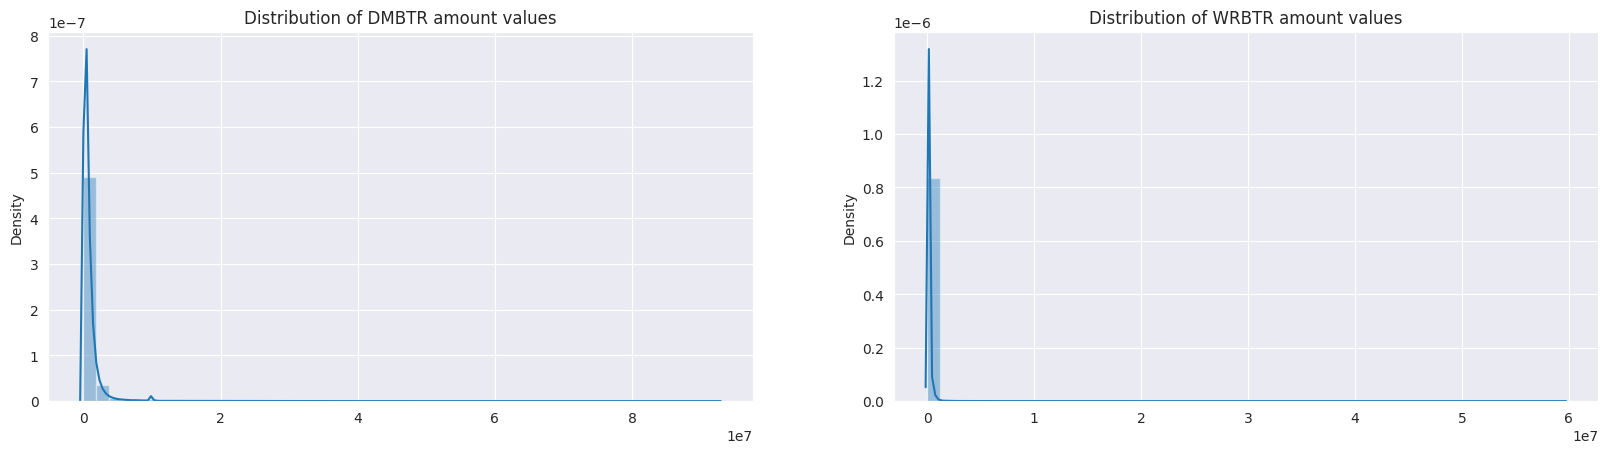

In [17]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

g = sns.distplot(df['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

g = sns.distplot(df['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

## Log Transform and Normalization

In [18]:
numerical = ['DMBTR', 'WRBTR']

num_df = df[numerical] + 1e-7
num_df = num_df.apply(np.log)

# normalize all numeric attributes to the range [0,1]
num_df = (num_df - num_df.min()) / (num_df.max() - num_df.min())

In [19]:
df2 = pd.concat([num_df, labels], axis=1)


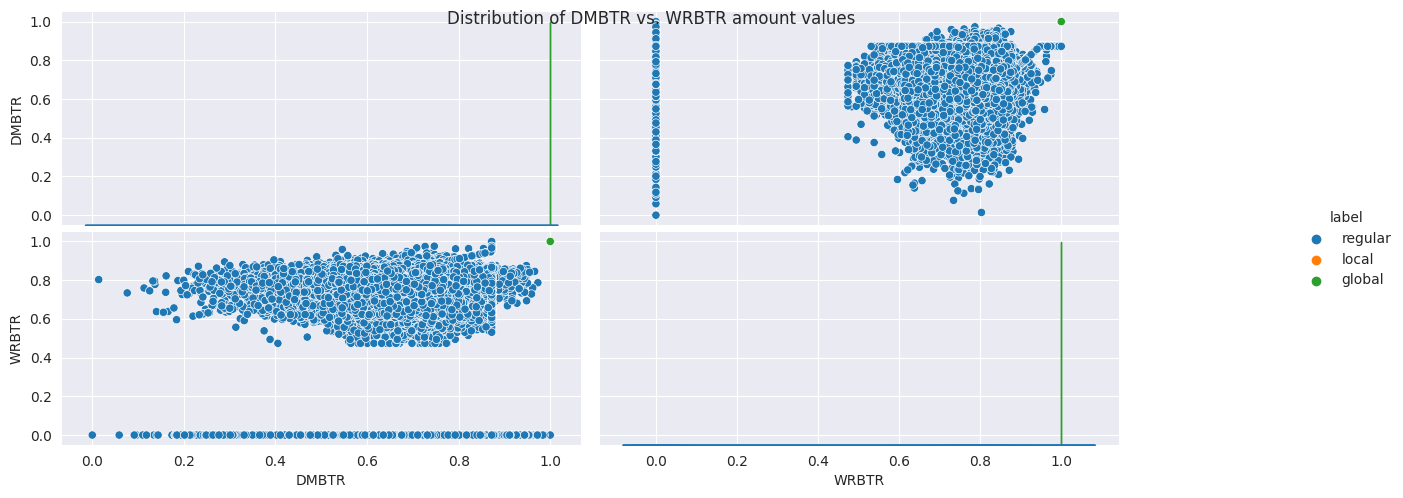

In [20]:
g = sns.pairplot(data=df2,  hue='label')
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values')
g.fig.set_size_inches(15, 5)


In [21]:
final_df=pd.concat([cat_df,num_df],axis=1)

In [22]:
final_df.shape

(533009, 618)

## Auto-Encoders Neural Network

### Encoder

In [23]:
class encoder (nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        self.encoder_L1 = nn.Linear(in_features=618, out_features=3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L1.weight) 
        self.encoder_A1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) 
    
    def forward(self,x):
        x=self.encoder_A1(self.encoder_L1(x))
        return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
encoder1=encoder()
encoder1.to(device)

encoder(
  (encoder_L1): Linear(in_features=618, out_features=3, bias=True)
  (encoder_A1): LeakyReLU(negative_slope=0.4, inplace=True)
)

### Decoder

In [26]:
class decoder (nn.Module):
    def __init__(self):
        super(decoder,self).__init__()
        self.decoder_L1 = nn.Linear(in_features=3, out_features=618, bias=True)
        nn.init.xavier_uniform_(self.decoder_L1.weight) 
        self.decoder_A1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) 
    
    def forward(self,x):
        x=self.decoder_A1(self.decoder_L1(x))
        return x

In [27]:
decoder1=decoder()
decoder1.to(device)

decoder(
  (decoder_L1): Linear(in_features=3, out_features=618, bias=True)
  (decoder_A1): LeakyReLU(negative_slope=0.4, inplace=True)
)

In [28]:
loss_fn=nn.BCEWithLogitsLoss(reduction='mean')

In [31]:
encoder_optimizer = torch.optim.Adam(encoder1.parameters(), lr=1e-3)
decoder_optimizer = torch.optim.Adam(decoder1.parameters(), lr=1e-3)

In [32]:
numpy_array=final_df.values
tensor=torch.from_numpy(numpy_array).float()
tensor_gpu=tensor.to(device)


In [33]:
dataset = TensorDataset(tensor_gpu)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)


In [34]:
model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [35]:
loss_history = []
start_epoch=1
end_epoch=26

In [36]:
from tqdm import tqdm

In [39]:
for epoch in range(start_epoch, end_epoch):
    encoder1.train()
    decoder1.train()
    for batch in tqdm(dataloader, desc=f'Epoch {epoch}/{end_epoch - 1}'):
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()
        z_representation=encoder1(batch[0])
        outputs=decoder1(z_representation)
        loss = loss_fn(outputs, batch[0])
        loss.backward()
        decoder_optimizer.step()
        encoder_optimizer.step()
    
    
    # Evaluation Phase
    encoder1.eval()
    decoder1.eval()

    # reconstruct encoded transactional data
    reconstruction = decoder1(encoder1(tensor_gpu))
    
    # determine reconstruction loss - all transactions
    reconstruction_loss_all = loss_fn(reconstruction, tensor_gpu)
    eval_loss=reconstruction_loss_all.item()
    # collect reconstruction loss
    loss_history.append(eval_loss)
    print(f'Epoch {epoch}/{end_epoch - 1} - evaluation Loss: {eval_loss:.2f}')
   
        
    # Save the model weights
    model_save_path = os.path.join(model_dir, f'encoder_model_epoch_{epoch}.pth')
    torch.save(encoder1.state_dict(), model_save_path)
    print(f'Encoder Model saved for epoch {epoch} at {model_save_path}')
    
    model_save_path = os.path.join(model_dir, f'decoder_model_epoch_{epoch}.pth')
    torch.save(decoder1.state_dict(), model_save_path)
    print(f'Decoder Model saved for epoch {epoch} at {model_save_path}')

Epoch 1/25: 100%|██████████| 4165/4165 [00:09<00:00, 450.58it/s]


Epoch 1/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 1 at model/encoder_model_epoch_1.pth
Decoder Model saved for epoch 1 at model/decoder_model_epoch_1.pth


Epoch 2/25: 100%|██████████| 4165/4165 [00:09<00:00, 445.19it/s]


Epoch 2/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 2 at model/encoder_model_epoch_2.pth
Decoder Model saved for epoch 2 at model/decoder_model_epoch_2.pth


Epoch 3/25: 100%|██████████| 4165/4165 [00:09<00:00, 452.14it/s]


Epoch 3/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 3 at model/encoder_model_epoch_3.pth
Decoder Model saved for epoch 3 at model/decoder_model_epoch_3.pth


Epoch 4/25: 100%|██████████| 4165/4165 [00:09<00:00, 452.98it/s]


Epoch 4/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 4 at model/encoder_model_epoch_4.pth
Decoder Model saved for epoch 4 at model/decoder_model_epoch_4.pth


Epoch 5/25: 100%|██████████| 4165/4165 [00:09<00:00, 447.06it/s]


Epoch 5/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 5 at model/encoder_model_epoch_5.pth
Decoder Model saved for epoch 5 at model/decoder_model_epoch_5.pth


Epoch 6/25: 100%|██████████| 4165/4165 [00:09<00:00, 448.47it/s]


Epoch 6/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 6 at model/encoder_model_epoch_6.pth
Decoder Model saved for epoch 6 at model/decoder_model_epoch_6.pth


Epoch 7/25: 100%|██████████| 4165/4165 [00:09<00:00, 454.22it/s]


Epoch 7/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 7 at model/encoder_model_epoch_7.pth
Decoder Model saved for epoch 7 at model/decoder_model_epoch_7.pth


Epoch 8/25: 100%|██████████| 4165/4165 [00:09<00:00, 446.51it/s]


Epoch 8/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 8 at model/encoder_model_epoch_8.pth
Decoder Model saved for epoch 8 at model/decoder_model_epoch_8.pth


Epoch 9/25: 100%|██████████| 4165/4165 [00:09<00:00, 450.78it/s]


Epoch 9/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 9 at model/encoder_model_epoch_9.pth
Decoder Model saved for epoch 9 at model/decoder_model_epoch_9.pth


Epoch 10/25: 100%|██████████| 4165/4165 [00:09<00:00, 449.53it/s]


Epoch 10/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 10 at model/encoder_model_epoch_10.pth
Decoder Model saved for epoch 10 at model/decoder_model_epoch_10.pth


Epoch 11/25: 100%|██████████| 4165/4165 [00:09<00:00, 448.68it/s]


Epoch 11/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 11 at model/encoder_model_epoch_11.pth
Decoder Model saved for epoch 11 at model/decoder_model_epoch_11.pth


Epoch 12/25: 100%|██████████| 4165/4165 [00:09<00:00, 443.55it/s]


Epoch 12/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 12 at model/encoder_model_epoch_12.pth
Decoder Model saved for epoch 12 at model/decoder_model_epoch_12.pth


Epoch 13/25: 100%|██████████| 4165/4165 [00:09<00:00, 451.24it/s]


Epoch 13/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 13 at model/encoder_model_epoch_13.pth
Decoder Model saved for epoch 13 at model/decoder_model_epoch_13.pth


Epoch 14/25: 100%|██████████| 4165/4165 [00:09<00:00, 452.39it/s]


Epoch 14/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 14 at model/encoder_model_epoch_14.pth
Decoder Model saved for epoch 14 at model/decoder_model_epoch_14.pth


Epoch 15/25: 100%|██████████| 4165/4165 [00:09<00:00, 451.07it/s]


Epoch 15/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 15 at model/encoder_model_epoch_15.pth
Decoder Model saved for epoch 15 at model/decoder_model_epoch_15.pth


Epoch 16/25: 100%|██████████| 4165/4165 [00:09<00:00, 452.70it/s]


Epoch 16/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 16 at model/encoder_model_epoch_16.pth
Decoder Model saved for epoch 16 at model/decoder_model_epoch_16.pth


Epoch 17/25: 100%|██████████| 4165/4165 [00:09<00:00, 452.15it/s]


Epoch 17/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 17 at model/encoder_model_epoch_17.pth
Decoder Model saved for epoch 17 at model/decoder_model_epoch_17.pth


Epoch 18/25: 100%|██████████| 4165/4165 [00:09<00:00, 448.17it/s]


Epoch 18/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 18 at model/encoder_model_epoch_18.pth
Decoder Model saved for epoch 18 at model/decoder_model_epoch_18.pth


Epoch 19/25: 100%|██████████| 4165/4165 [00:09<00:00, 452.09it/s]


Epoch 19/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 19 at model/encoder_model_epoch_19.pth
Decoder Model saved for epoch 19 at model/decoder_model_epoch_19.pth


Epoch 20/25: 100%|██████████| 4165/4165 [00:09<00:00, 451.40it/s]


Epoch 20/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 20 at model/encoder_model_epoch_20.pth
Decoder Model saved for epoch 20 at model/decoder_model_epoch_20.pth


Epoch 21/25: 100%|██████████| 4165/4165 [00:09<00:00, 454.51it/s]


Epoch 21/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 21 at model/encoder_model_epoch_21.pth
Decoder Model saved for epoch 21 at model/decoder_model_epoch_21.pth


Epoch 22/25: 100%|██████████| 4165/4165 [00:09<00:00, 448.34it/s]


Epoch 22/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 22 at model/encoder_model_epoch_22.pth
Decoder Model saved for epoch 22 at model/decoder_model_epoch_22.pth


Epoch 23/25: 100%|██████████| 4165/4165 [00:09<00:00, 454.64it/s]


Epoch 23/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 23 at model/encoder_model_epoch_23.pth
Decoder Model saved for epoch 23 at model/decoder_model_epoch_23.pth


Epoch 24/25: 100%|██████████| 4165/4165 [00:09<00:00, 454.96it/s]


Epoch 24/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 24 at model/encoder_model_epoch_24.pth
Decoder Model saved for epoch 24 at model/decoder_model_epoch_24.pth


Epoch 25/25: 100%|██████████| 4165/4165 [00:09<00:00, 447.03it/s]


Epoch 25/25 - evaluation Loss: 0.02
Encoder Model saved for epoch 25 at model/encoder_model_epoch_25.pth
Decoder Model saved for epoch 25 at model/decoder_model_epoch_25.pth


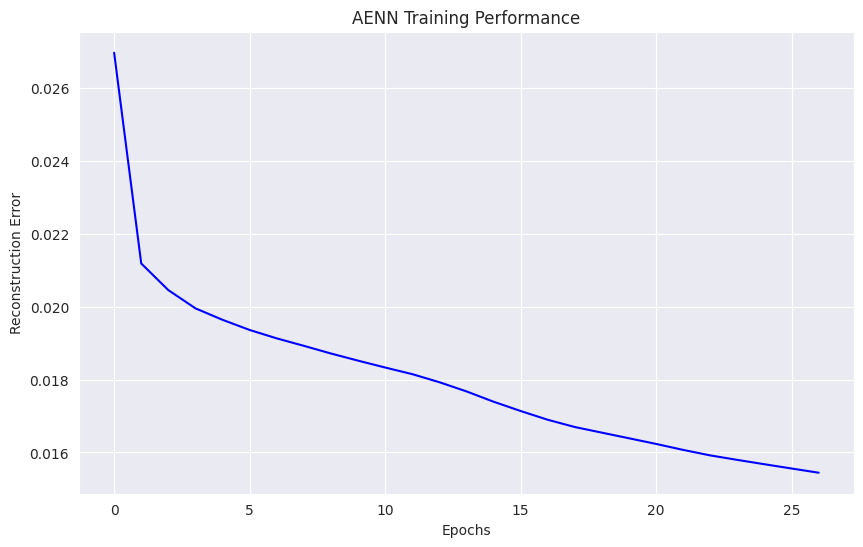

In [41]:
# Creating the plot
plt.figure(figsize=(10, 6))  # Optional: You can adjust the figure size
plt.plot(loss_history, linestyle='-', color='b')  # Line plot with x-axis shifted by 1

# Adding title and labels
plt.title('AENN Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Error')

# Optionally, add a grid for easier reading
plt.grid(True)

# Show the plot
plt.show()

## Evaluating Transactions

In [42]:
encoder_model_name = "/kaggle/working/model/encoder_model_epoch_25.pth"
decoder_model_name = "/kaggle/working/model/decoder_model_epoch_25.pth"

# init training network classes / architectures
encoder2 = encoder()
decoder2 = decoder()

# load trained models
encoder2.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))
decoder2.load_state_dict(torch.load(os.path.join("models", decoder_model_name)))

<All keys matched successfully>

In [45]:
encoder2.to(device)
decoder2.to(device)

decoder(
  (decoder_L1): Linear(in_features=3, out_features=618, bias=True)
  (decoder_A1): LeakyReLU(negative_slope=0.4, inplace=True)
)

In [43]:
encoder2.eval()
decoder2.eval()

decoder(
  (decoder_L1): Linear(in_features=3, out_features=618, bias=True)
  (decoder_A1): LeakyReLU(negative_slope=0.4, inplace=True)
)

In [48]:
reconstruction=decoder2(encoder2(tensor_gpu))
reconstruction_loss = loss_fn(reconstruction, tensor_gpu)

In [50]:
print(f"Reconstruction Loss:{reconstruction_loss:.5f}")

Reconstruction Loss:0.01544


In [51]:
reconstruction.size()

torch.Size([533009, 618])

In [54]:
# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_fn(reconstruction[i], tensor_gpu[i]).item()

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))
        

[LOG 20240813-03:40:21] collected individual reconstruction loss of: 000000/533009 transactions
[LOG 20240813-03:40:34] collected individual reconstruction loss of: 100000/533009 transactions
[LOG 20240813-03:40:48] collected individual reconstruction loss of: 200000/533009 transactions
[LOG 20240813-03:41:02] collected individual reconstruction loss of: 300000/533009 transactions
[LOG 20240813-03:41:16] collected individual reconstruction loss of: 400000/533009 transactions
[LOG 20240813-03:41:29] collected individual reconstruction loss of: 500000/533009 transactions


In [64]:
threshold = np.percentile(reconstruction_loss_transaction, 95)  # Set threshold at the 95th percentile


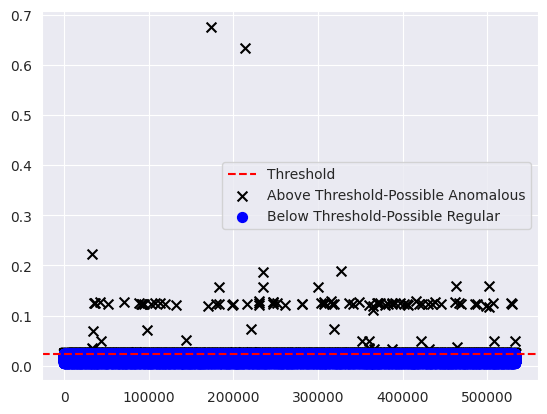

In [73]:
# Prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

# Plot threshold line
ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

# Optionally, highlight points above the threshold
above_threshold = plot_data[plot_data[:, 1] > threshold]
below_threshold = plot_data[plot_data[:, 1] < threshold]
ax.scatter(above_threshold[:, 0], above_threshold[:, 1], c='black', marker='x', s=50, label='Above Threshold-Possible Anomalous')
ax.scatter(below_threshold[:, 0], below_threshold[:, 1], c='blue', marker='o', s=50, label='Below Threshold-Possible Regular')

# Add plot legend of transaction classes
ax.legend(loc='best')

In [59]:
label=labels['label'].values

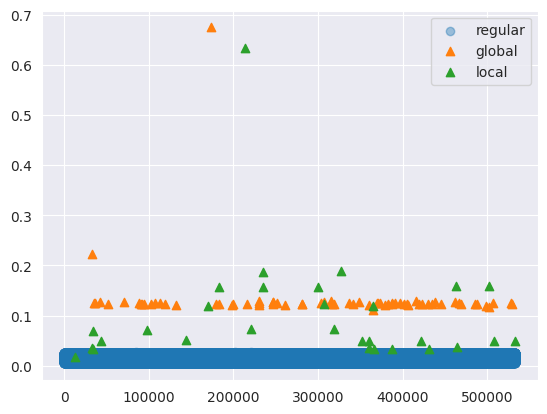

In [63]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

# obtain regular transactions as well as global and local anomalies
regular_data = plot_data[label == 'regular']
global_outliers = plot_data[label == 'global']
local_outliers = plot_data[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o", label='regular') # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", label='global') # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="^", label='local') # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best')

## Inference
#### The decoder will be able to reconstruct the original data for regular transactions hence the loss is very low where as the loss is high for some cases which indicates these are anomalous one's and the above two figure justifies it.